In [1]:
import os
# Find the latest version of spark 3.2 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [2]:
from pyspark.sql import functions as F
from pyspark.sql import types as T


#Gives a label to each category
#creates onehot encoding vector
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#Used to creat vector from features and modeling takes vector as an input
from pyspark.ml.feature import VectorAssembler

#Used for classification problems
from pyspark.ml.classification import DecisionTreeClassifier



In [3]:
# Start Spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, when
spark = SparkSession.builder.appName("BankChurners").getOrCreate()

In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://groupfourproject.s3.ca-central-1.amazonaws.com/bank_churners.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("bank_churners.csv"), header=True, sep=',', inferSchema=True)


# Show DataFrame
df.show()

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

In [5]:
#Dropping duplicates within the dataframe
df.dropDuplicates().show()

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

In [6]:
credit_df= df.drop('CLIENTNUM', 'Customer_Age', 'Marital_Status',
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1')

credit_df.show()

+-----------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|   Attrition_Flag|Gender|Dependent_count|Education_Level|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+-----------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|Existing Customer|     M|              3|    Hig

In [7]:
#Maniplating Attrition_Flag to 0= Attrited Customer and 1= Existing Customer
attrition_df = credit_df.withColumn("Attrition_Flag", F.when(F.col("Attrition_Flag") =='Attrited Customer', 0).otherwise(1))

#Displaying DataFrame
attrition_df.show(3, truncate=False)

#Displaying count of Attrition_Flag
attrition_df.groupby("Attrition_Flag").count().show()



+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|Attrition_Flag|Gender|Dependent_count|Education_Level|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|1             |M     |3              |High School    |$60

In [8]:
from pyspark.sql import functions as F

# Perform groupBy and count operation on 'Attrition_Flag' column
attrition_flag_counts = credit_df.groupBy("Attrition_Flag").count()

# Join the original DataFrame with the DataFrame containing counts
updated_df = credit_df.join(attrition_flag_counts, "Attrition_Flag", "left")

df_8500 = updated_df.filter(updated_df["count"]==8500)
df_sample =df_8500.sample(fraction=1627.0/8500.0, seed=1)

df_1627 = updated_df.filter(updated_df["count"] !=8500)

# Combine the sampled data with the original data
updated_df = df_sample.union(df_1627)

# Show the updated DataFrame
updated_df.show()

updated_df.tail(10)
updated_df.show()


+-----------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----+
|   Attrition_Flag|Gender|Dependent_count|Education_Level|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|count|
+-----------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----+
|Existing Customer|     M|     

In [9]:
new_attrited_df = updated_df.withColumn("Attrition_Flag", F.when(F.col("Attrition_Flag") =='Attrited Customer', 0).otherwise(1))
new_attrited_df.show()

new_attrited_df.groupby("Attrition_Flag").count().show()


+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----+
|Attrition_Flag|Gender|Dependent_count|Education_Level|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|count|
+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----+
|             1|     M|              3| 

+--------------+-----+
|Attrition_Flag|count|
+--------------+-----+
|             1| 1684|
|             0| 1627|
+--------------+-----+



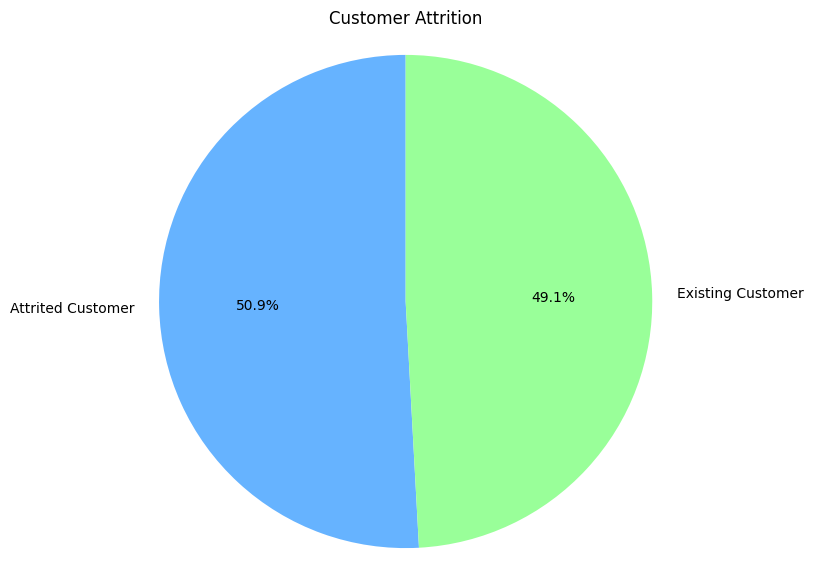

<Figure size 640x480 with 0 Axes>

In [10]:
attrition_counts = new_attrited_df.groupby("Attrition_Flag").count()
attrition_counts.show()

#Convert Spark DataFrame to Pandas DataFrame
attrition_counts_pd = attrition_counts.toPandas()

# Create a pie chart using Matplotlib
import matplotlib.pyplot as plt

# Labels for the pie chart
labels = ['Attrited Customer', 'Existing Customer']

# Define custom colors
colors = ['#66b3ff','#99ff99']

# Values for the pie chart
sizes = attrition_counts_pd['count']

# Plotting the pie chart
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Customer Attrition')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Save the figure
plt.savefig("Balanced Dataset.png")

# Show the plot
plt.show()

**2nd Modeling**

In [11]:
(train_df_2, test_df_2) = new_attrited_df.randomSplit([0.8, 0.2], 11)
print("Number of train samples: " + str(train_df_2.count()))
print("Number of test samples: " + str(test_df_2.count()))

Number of train samples: 2632
Number of test samples: 679


In [12]:
# Apply StringIndexer to the Attrition_Flag column
attrition_indexer_2 = StringIndexer(inputCol="Attrition_Flag", outputCol="Attrition_Flag_Index")
attrition_indexer_2 = attrition_indexer_2.fit(train_df_2)
attrited_train_df_2 = attrition_indexer_2.transform(train_df_2)

# Show the transformed DataFrame
attrited_train_df_2.show(n=3, truncate=False)

+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----+--------------------+
|Attrition_Flag|Gender|Dependent_count|Education_Level|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|count|Attrition_Flag_Index|
+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----

In [13]:
attrited_train_df_2.tail(50)
attrited_train_df_2.show()

+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----+--------------------+
|Attrition_Flag|Gender|Dependent_count|Education_Level|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|count|Attrition_Flag_Index|
+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----

In [14]:
inputCols_2=[
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio'
    ]

outputCol_2="features"

vector_assembler_2 = VectorAssembler(inputCols= inputCols_2, outputCol=outputCol_2)
train_df2 = vector_assembler_2.transform(train_df_2)

In [15]:
train_df2.show(3, truncate=False)

+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----+------------------------------------------------------------------------+
|Attrition_Flag|Gender|Dependent_count|Education_Level|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|count|features                                                                |
+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+-----------

In [16]:
#Modeling dataframe for Attrition_Flag
modeling_df_2 = train_df2.select(['features', 'Attrition_Flag'])

#Displaying top DataFrame
modeling_df_2.show()

#Displaying bottom DataFrame
modeling_df_2.tail(10)
modeling_df_2.show()

+--------------------+--------------+
|            features|Attrition_Flag|
+--------------------+--------------+
|[0.0,13.0,2.0,3.0...|             1|
|[0.0,46.0,6.0,2.0...|             1|
|[0.0,53.0,3.0,2.0...|             1|
|[0.0,30.0,3.0,2.0...|             1|
|[0.0,36.0,1.0,2.0...|             1|
|[0.0,56.0,5.0,2.0...|             1|
|[0.0,51.0,3.0,3.0...|             1|
|[0.0,36.0,1.0,1.0...|             1|
|[0.0,36.0,3.0,1.0...|             1|
|[0.0,45.0,5.0,2.0...|             1|
|[0.0,50.0,3.0,2.0...|             1|
|[0.0,56.0,4.0,3.0...|             1|
|[0.0,45.0,6.0,3.0...|             1|
|[0.0,17.0,4.0,1.0...|             1|
|[0.0,20.0,5.0,1.0...|             1|
|[0.0,26.0,3.0,1.0...|             1|
|[0.0,26.0,6.0,1.0...|             1|
|[0.0,32.0,2.0,2.0...|             1|
|[0.0,36.0,2.0,2.0...|             1|
|[0.0,36.0,4.0,3.0...|             1|
+--------------------+--------------+
only showing top 20 rows

+--------------------+--------------+
|            features|At

In [17]:
#Creating a DecisionTreeClassifier model
model_attrition_2 = DecisionTreeClassifier(labelCol="Attrition_Flag", featuresCol="features")

#Train model
model_attrition_2 = model_attrition_2.fit(modeling_df_2)

In [18]:
prediction = model_attrition_2.transform(modeling_df_2)
prediction.show()

+--------------------+--------------+-------------+--------------------+----------+
|            features|Attrition_Flag|rawPrediction|         probability|prediction|
+--------------------+--------------+-------------+--------------------+----------+
|[0.0,13.0,2.0,3.0...|             1|  [4.0,619.0]|[0.00642054574638...|       1.0|
|[0.0,46.0,6.0,2.0...|             1|  [4.0,619.0]|[0.00642054574638...|       1.0|
|[0.0,53.0,3.0,2.0...|             1|  [4.0,619.0]|[0.00642054574638...|       1.0|
|[0.0,30.0,3.0,2.0...|             1|   [5.0,73.0]|[0.06410256410256...|       1.0|
|[0.0,36.0,1.0,2.0...|             1|  [6.0,186.0]|   [0.03125,0.96875]|       1.0|
|[0.0,56.0,5.0,2.0...|             1|  [4.0,619.0]|[0.00642054574638...|       1.0|
|[0.0,51.0,3.0,3.0...|             1| [45.0,235.0]|[0.16071428571428...|       1.0|
|[0.0,36.0,1.0,1.0...|             1|  [6.0,186.0]|   [0.03125,0.96875]|       1.0|
|[0.0,36.0,3.0,1.0...|             1|   [25.0,2.0]|[0.92592592592592...|    

In [19]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Attrition_Flag")


accuracy = evaluator.evaluate(prediction, {evaluator.metricName: 'accuracy'})
f1 = evaluator.evaluate(prediction, {evaluator.metricName: 'f1'})
recall = evaluator.evaluate(prediction, {evaluator.metricName: 'recallByLabel'})
precision = evaluator.evaluate(prediction, {evaluator.metricName: 'precisionByLabel'})

print(f"The Precision for 2nd Train Prediction: {precision}")
print(f"The F1 for 2nd Train Prediction: {f1}")
print(f"The Recall for 2nd Train Prediction: {recall}")
print(f"The Accuracy for 2nd Train Prediction: {accuracy}")



The Precision for 2nd Train Prediction: 0.9309791332263242
The F1 for 2nd Train Prediction: 0.9205489536427204
The Recall for 2nd Train Prediction: 0.9041309431021044
The Accuracy for 2nd Train Prediction: 0.9205927051671733


**2nd Test Prediction**

In [20]:
test_df_2 = attrition_indexer_2 .transform(test_df_2)
test_df_2 = vector_assembler_2.transform(test_df_2)
test_predications = model_attrition_2.transform(test_df_2)

test_predications.show(3, truncate=False)

+--------------+------+---------------+---------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----+--------------------+-------------------------------------------------------------------------+-------------+-----------------------------------------+----------+
|Attrition_Flag|Gender|Dependent_count|Education_Level|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|count|Attrition_Flag_Index|features                                                                 |rawPrediction|probability                              |prediction|
+--------------+------+-------------

In [21]:
evaluator = MulticlassClassificationEvaluator(labelCol="Attrition_Flag")

accuracy = evaluator.evaluate(test_predications, {evaluator.metricName: 'accuracy'})
f1 = evaluator.evaluate(test_predications, {evaluator.metricName: 'f1'})
recall = evaluator.evaluate(test_predications, {evaluator.metricName: 'recallByLabel'})
precision = evaluator.evaluate(test_predications, {evaluator.metricName: 'precisionByLabel'})

print(f"The Precision for 2nd Test Prediction: {precision}")
print(f"The F1 for 2nd Test Prediction: {f1}")
print(f"The Recall for 2nd Test Prediction: {recall}")
print(f"The Accuracy for 2nd Test Prediction: {accuracy}")

The Precision for 2nd Test Prediction: 0.9101796407185628
The F1 for 2nd Test Prediction: 0.8969049804028901
The Recall for 2nd Test Prediction: 0.8837209302325582
The Accuracy for 2nd Test Prediction: 0.8969072164948454
